1. 从零开始实现基于NumPy和SciPy包的预期改进获取函数
2. 使用一个现成的BO包来完成相同的任务

In [11]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
%matplotlib inline



In [12]:
# Define the objective function and search domain 
bounds = np.array([[-1.0, 2.0]])
noise = 0.2

# Objective function
def f(x, noise=0):
    return -np.sin(3*x) - x**2 + 0.7*x + noise * np.random.randn(*x.shape)



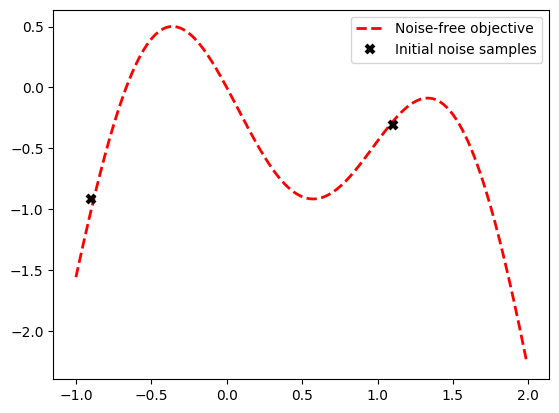

In [13]:
# Visualize the noise-free objective function
X_init = np.array([[-0.9], [1.1]])
Y_init = f(X_init, noise=noise)

X_plot = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)
Y_plot = f(X_plot, noise=0)
plt.plot(X_plot, Y_plot, 'r--', lw=2, label='Noise-free objective')
plt.plot(X_init, Y_init, 'kx', mew=3, label='Initial noise samples')
plt.legend()

In [14]:

def expected_improvement(X,X_sample, Y_sample, gpr, xi=0.01):
    '''
    Computes the EI at points X based on existing samples X_sample and Y_sample using a Gaussian process surrogate model.
    
    Args:
        X: Points at which EI shall be computed (m x d).
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.
    
    Returns:
        Expected improvements at points X.
    '''
    
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)
    
    sigma = sigma.reshape(-1, 1)
    
    # Needed for noise-based model,
    # otherwise use np.max(Y_sample).
    mu_sample_opt = np.max(mu_sample)
    
    # np.errstate 是一个上下文管理器，用于临时改变NumPy的警告设置。在这里，divide='warn' 表示如果发生除以零的操作，NumPy将发出警告而不是错误。
    with np.errstate(divide='warn'):
        # 改进量的计算 xi是一个很小的值，避免分母为0
        imp = mu - mu_sample_opt - xi 
        # Z是标准化的改进量（改进量除以标准差）
        Z = imp / sigma
     
        """
        EI的计算
        imp * norm.cdf(Z)：概率加权的改进量
        这部分计算的是，如果新点的目标函数值确实比当前最佳值好，那么这种改进量的期望值是多少。
        这里，norm.cdf(Z) 给出了新点目标函数值超过当前最佳值的概率，而 imp 是这种改进量的大小。
        将两者相乘，我们得到了在新点找到更好解的预期概率加权改进量。


        sigma * norm.pdf(Z)：概率密度加权的改进量 
        这部分计算的是，即使新点的目标函数值没有超过当前最佳值，它仍然有可能在当前最佳值附近。
        norm.pdf(Z) 给出了新点目标函数值在当前最佳值附近的概率密度，而 sigma 是目标函数值的不确定性（标准差）。
        将两者相乘，我们得到了在新点目标函数值接近当前最佳值时的预期改进量。


        两部分相加得到一个全面的预期改进量
        """
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0 # 检查标准差（sigma）是否为零。如果为零，说明目标函数的方差非常小，或者函数是确定性的，因此不可能有改进。在这种情况下，Expected Improvement 被设置为零，因为没有任何改进的空间。
    
    return ei

In [15]:
def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    '''
    Proposes the next sampling point by optimizing the acquisition function.
    
    Args:
        acquisition: Acquisition function.
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
        bounds: Bounds of the variable.
        n_restarts:  为了避免Local optima，我们可以多次随机初始化优化算法的起始点。
    
    Returns:
        Location of the acquisition function maximum.
    '''
    
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)
    
    #使用了SciPy库中的minimize函数来执行优化任务。代码的目的是找到给定目标函数（min_obj）的最小值，同时考虑到变量的边界约束。
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        # np.random.uniform在这个边界内均匀地随机生成n_restarts个初始点，每个点有dim个变量。
        # bounds[:, 0]和bounds[:, 1]分别定义了每个变量的最小值和最大值，这些值构成了优化问题的边界约束。
        # 在 "L-BFGS-B" 中，"B" 代表 "Box"，意味着这个算法被设计来处理带有边界约束的优化问题。在这种情况下，变量的取值范围被限制在一个盒子（或称为超立方体）内。
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')
        
        if res.fun < min_val:
            min_val = res.fun[0]
            min_x = res.x
            
    return min_x.reshape(-1, 1)

In [16]:
def plot_approximation(gpr, X_plot, Y_plot, X_sample, Y_sample, X_next=None, show_legend=False):
    mu, std = gpr.predict(X_plot, return_std=True)
    plt.fill_between(X_plot.ravel(),mu.ravel() + 1.96 * std, mu.ravel() - 1.96 * std, alpha=0.1)
    plt.plot(X_plot, Y_plot, 'r-', lw=1, label='Noise-free objective')
    plt.plot(X_plot, mu, 'b-', lw=1, label='Surrogate function')
    plt.plot(X_sample, Y_sample, 'kx', mew=3, label='Noisy samples')

    if X_next:
        plt.axvline(x=X_next,color='k',linestyle='--', lw=1)
    if show_legend:
        plt.legend()

def plot_acquisition(X_plot, acq_value, X_next, show_legend=False):
    plt.plot(X_plot, acq_value, 'r-', lw=1, label='Acquisition function')
    plt.axvline(x=X_next,color='k',linestyle='--', lw=1, label='Next sampling location')
    if show_legend:
        plt.legend()

def plot_convergence(X_sample, Y_sample, n_init=2):
    plt.figure(figsize=(12, 3))

    x = X_sample[n_init:].ravel()
    y = Y_sample[n_init:].ravel()
    r = range(1, len(x)+1)
  
    x_neighbor_dist = [np.abs(a-b) for a, b in zip(x, x[1:])]
    y_max = np.maximum.accumulate(y)

    plt.subplot(1, 2, 1)
    plt.plot(r[1:], x_neighbor_dist, 'bo-')
    plt.xlabel('Iteration')
    plt.ylabel('Distance')
    plt.title('Distance between consecutive x\'s')
    plt.subplot(1, 2, 2)
    plt.plot(r, y_max, 'ro-')
    plt.xlabel('Iteration')
    plt.ylabel('Best Y')
    plt.title('Value of best selected sample')

In [17]:
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)